<h1> Карташов Антон Валерьевич 
    <h2> Вариант 2

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. <br>
<b>!Необходимо!</b> проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [1]:
# импорт библиотек

import pandas as pd # мир пандам
import numpy as np

import scipy.stats as st # Статистика 

import matplotlib.pyplot as plt #Графики - сила
import seaborn as sb
import plotly.express as px
import plotly.graph_objects as go
import funBood

%matplotlib inline

In [4]:
groups       = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/58Us0DWOzuWAjg', sep = ';')
active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/prbgU-rZpiXVYg', sep = ';')
checks       = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/84hTmELphW2sqQ', sep = ';')

<h2> Что имеем </h2> <br>
<b>groups.csv</b> - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) <br><br>
<b>active_studs.csv</b> - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. <br><br>
<b>checks.csv</b> - файл с информацией об оплатах пользователей в дни проведения эксперимента. <br><br>
Выведем информацию, что храниться в этих "лесах".

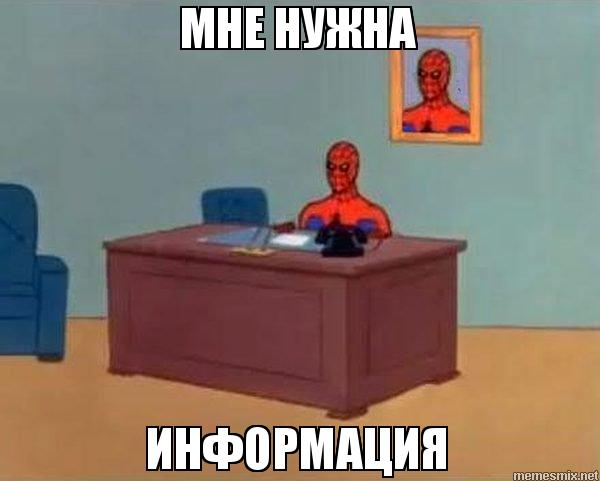

In [5]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [6]:
groups.head()

id grp
0  1489   B
1  1627   A
2  1768   B
3  1783   B
4  1794   A

In [7]:
checks = checks.rename(columns={'student_id':'id'})
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      541 non-null    int64  
 1   rev     541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [8]:
checks.head()

id    rev
0    1627  990.0
1    3185  690.0
2   25973  690.0
3   26280  690.0
4  100300  990.0

In [9]:
active_studs = active_studs.rename(columns={'student_id':'id'})
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [10]:
active_studs.head()

id
0   581585
1  5723133
2  3276743
3  4238589
4  4475369

 <br><br><h2>Определим метрики на которые необходимо посмотреть во время анализа:</h2><br><br>

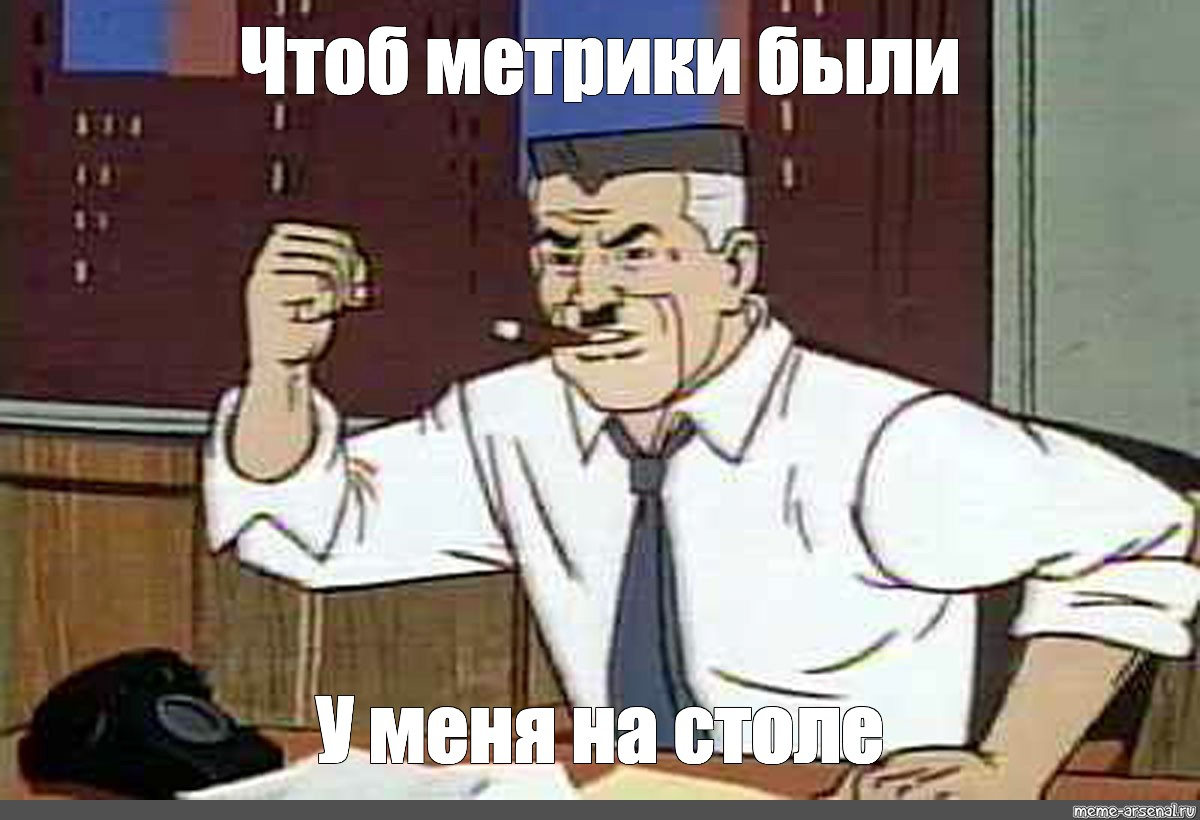

У нас есть определенный период исследования.
Мы знаем не так и много всего: количество пользователей в тестовой группе, количество активных пользователей ( пользователи которые зашли на сайт ) и сумму потраченную на товар:
 <br>=> мы можем использовать такие метрики:<br>
 <br>
 <br><b>CR в посетитель</b> (отношение колличества активных юзеров на всех юзеров в тесте);
 <br><b>СR посетитель в покупку</b> (отношение активных пользователей в покупку);
 <br><b>ARPU</b> (отношение общего дохода к числу пользователей участвующих в тесте);
 <br><b>ARPAU</b> (отношение общего дохода к числу активных пользователей).
 <br> (активный пользователь - это тот кто перешел на сайт из тестовой группы)<br>
 <br>Также можно посмотреть и средний чек, максимальный чек, суммарный чек, а также колличество покупок.

<h2>Для начала давайте объединим таблицы и расчитаем средний чек, максимальный чек, количество покупок</h2> <br><br>

Метод объединения inner так как нужно знать только тех юзеров, которые были выбранны как "тестировщики".

In [9]:
by_chek    = checks.merge(groups, on='id') # юзеры которые совершили покупку с их чеком

mean_chek  = by_chek.groupby('grp',as_index=False).agg({'rev':pd.Series.mean}).rename(columns={'rev':'mean_ch'}) # стредний чек
max_chek   = by_chek.groupby('grp',as_index=False).agg({'rev':pd.Series.max}).rename(columns={'rev':'max_ch'}) # максимальный чек
count_chek = by_chek.groupby('grp',as_index=False).agg({'rev':pd.Series.count}).rename(columns={'rev':'count_ch'}) # кооличество чеков
sum_chek   = by_chek.groupby('grp',as_index=False).agg({'rev':pd.Series.sum}).rename(columns={'rev':'sum_ch'}) # суммарный чек

join_table_chek = mean_chek.merge(max_chek,on='grp').merge(count_chek,on='grp').merge(sum_chek,on='grp') # сводная

join_table_chek

grp      mean_ch  max_ch  count_ch       sum_ch
0   A   860.710280  3660.0     107.0   92096.0000
1   B  1106.997699  4650.0     433.0  479330.0036

In [10]:
# выводим значения

print('Разница между количеством покупок:', join_table_chek.query("grp=='B'")['count_ch'][1]\
                                            -join_table_chek.query("grp=='A'")['count_ch'][0])

print('Разница между средними чеком:', round(join_table_chek.query("grp=='B'")['mean_ch'][1]\
                                            -join_table_chek.query("grp=='A'")['mean_ch'][0],2))

print('Разница между максимальным чеком:', join_table_chek.query("grp=='B'")['max_ch'][1]\
                                            -join_table_chek.query("grp=='A'")['max_ch'][0])

print('Разница между суммарным чеком:', round(join_table_chek.query("grp=='B'")['sum_ch'][1]\
                                            -join_table_chek.query("grp=='A'")['sum_ch'][0],2))

Разница между количеством покупок: 326.0
Разница между средними чеком: 246.29
Разница между максимальным чеком: 990.0
Разница между суммарным чеком: 387234.0


Построим Box граффики для визуализации

In [11]:
fig1 = go.Figure()

fig1.add_trace(go.Box(y = by_chek.query("grp=='A'").rev, name='Sample A',
                     marker_color = 'indianred'))

fig1.add_trace(go.Box(y = by_chek.query("grp=='B'").rev, name = 'Sample B',
                     marker_color = 'lightseagreen'))

fig1.show()

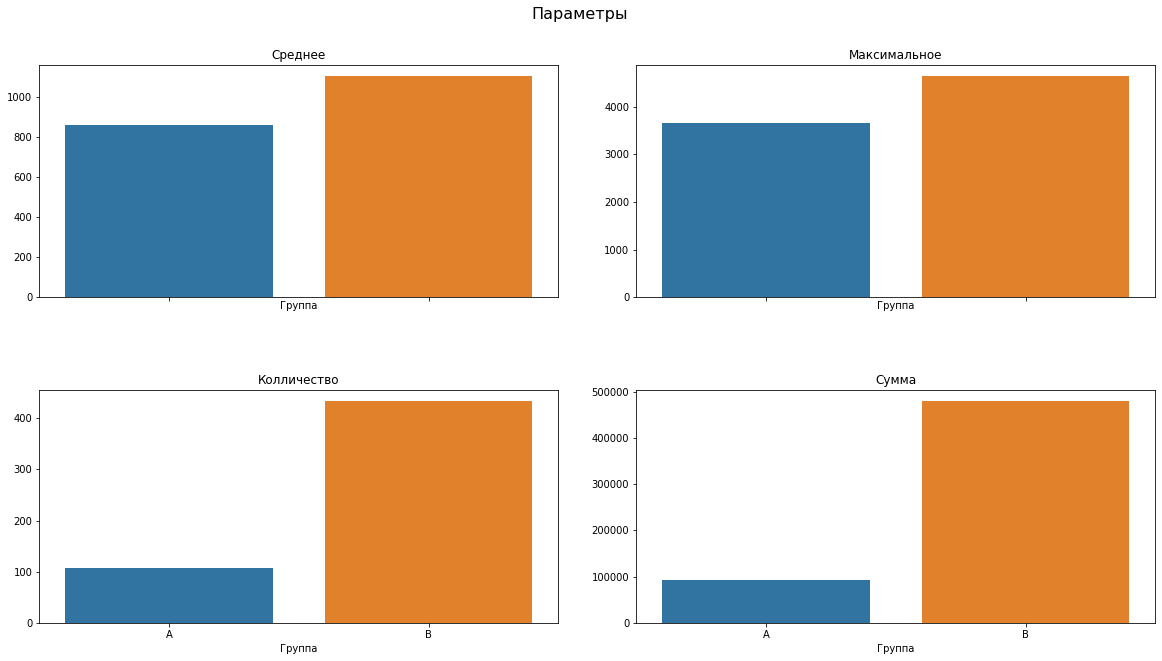

In [12]:
melt_table_for_plot = join_table_chek.melt(id_vars='grp')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), sharex=True)
fig.subplots_adjust(hspace=0.4, wspace=0.15)

columns=join_table_chek.columns
columns=columns.drop(['grp'])

fig.suptitle('Параметры', fontsize=16)
for ax,name,col in zip(axes.flatten(),['Cреднее','Максимальное','Колличество','Сумма'],columns):
    sb.barplot(data=join_table_chek,x=join_table_chek.grp, y=join_table_chek[col], ax=ax)
    ax.set(ylabel='', xlabel='Группа', title=name)
    
plt.subplots_adjust(top=0.9)

Как можно увидеть из граффика и получившимися показателями, что чаще всего покупали люди попавшие в эксперемернтальной греппе.<br>
Делать вывод только по графику – не очень хорошо, проведем статистический теста, чтобы определить, взаимосвязь между группами есть.
Для начала выдвенем гипотезу: чеки распределенны по нормальному закону?
для этого применем критерий 

In [13]:
print(st.shapiro(by_chek.query("grp=='A'").rev))
print(st.shapiro(by_chek.query("grp=='B'").rev))

ShapiroResult(statistic=0.7196124196052551, pvalue=5.321687643507211e-13)
ShapiroResult(statistic=0.867313027381897, pvalue=9.542798088039443e-19)


Отклоняем нулевую гипотезу и принимаем, что распределены чеки по нормальному закону. 
<br>Проведем тест Манна-Уитни и будстрепом по среднему для сравнии средних. Критерий отклонения нулевой гипотезы принемаем стандатным = 0.05.

In [14]:
p1   = st.mannwhitneyu(by_chek.query("grp=='A'").rev,by_chek.query("grp=='B'").rev)
t    = funBood.get_bootstrap(by_chek.query("grp=='A'").rev,by_chek.query("grp=='B'").rev)
resh = t["p_value"]

print('p-value при Bootstrap (среднее):', t["p_value"],
     '\np-value при mannwhitneyu:', p1[1])

if p1[1]<0.05 or resh<0.05:
    print('')
    print('Отклоняем нулевую гепотезу.' )
    print('Взаимосвязь между группами есть.')
    
else:
    print('')
    print('Принимаем нулевую гепотезу')
    print('Взаимосвязи между группами нет')


p-value при Bootstrap (среднее): 2.098757541885044e-06 
p-value при mannwhitneyu: 0.00021019690333618245

Отклоняем нулевую гепотезу.
Взаимосвязь между группами есть.


Вроде как успех! Анализ показал стат.значимые различия между группами. В группе В выше средний чек. Положительный сигнал. <b>Но не спешим и проверим наши метрики.
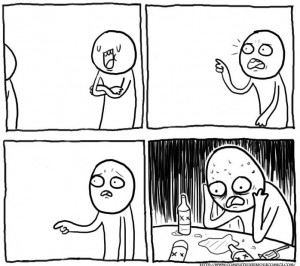

<b>Определим количество колличество активынх пользователей у каждой группы и рассичтаем метрики (СR, ARPU)</b>

In [15]:
activ_user = active_studs.merge(groups, on='id')
grp_activ  = activ_user.groupby('grp',as_index=False).agg({'id':pd.Series.count}).rename(columns={'id':'users'})

print('Разница между количеством активных пользователей:', grp_activ.query("grp=='B'")['users'][1]\
                                                           -grp_activ.query("grp=='A'")['users'][0])

Разница между количеством активных пользователей: 5258


In [16]:
fig1 = px.histogram(grp_activ , x="grp",y = 'users')
fig1.show()

Также можно увидеть что колличество активынх пользователей больше у эксперемента.
Неужели это успех?<br>
Проверим колличество пользователей у контрольной и у эксперементальной группы.

In [17]:
print('Контрольная группа:', groups.query("grp=='A'").id.count(),\
      ', процент от общего колличества: ', groups.query("grp=='A'").id.count()/groups.id.count()*100,'%')

print('Эксперементальная группа:', groups.query("grp=='B'").id.count(),\
      ', процент от общего колличества: ', groups.query("grp=='B'").id.count()/groups.id.count()*100,'%')

Контрольная группа: 14671 , процент от общего колличества:  19.69684764513184 %
Эксперементальная группа: 59813 , процент от общего колличества:  80.30315235486816 %


Как оказалось, что эксперементальная группа больше чем контрольная. <br>
Используем критерии Пирсона (критерий хи-квадрат), так как переменные у нас категориальные.<br>
- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть <br>

Проверим две гипотезы:<br>
1.Есть ли взаимосвязь между активностью пользователей?<br>
2.Есть ли взаимосвязь между переходами в покупку активных пользователей?

In [18]:
ToF_act = activ_user.merge(groups,on='id',how='right')
ToF_act['TF']=ToF_act.grp_x.notna()

ToF_act 

id grp_x grp_y     TF
0         1489   NaN     B  False
1         1627     A     A   True
2         1768   NaN     B  False
3         1783   NaN     B  False
4         1794   NaN     A  False
...        ...   ...   ...    ...
74479  5692459   NaN     B  False
74480  5692572   NaN     B  False
74481  5692865   NaN     B  False
74482  5693667   NaN     B  False
74483  5694419   NaN     B  False

[74484 rows x 4 columns]

На предыдущем шаге добавил новую переменную которая показывает был ли участьник теста активен или нет.<br>
Для этого использовал присоединение outer.<br>
Также определим новую переменную для активных пользователей, которые перешли к покупке.

In [19]:
ToF       = checks.merge(activ_user,on='id',how='outer')
ToF['TF'] = ToF.rev.isna()
ToF       =ToF.dropna(subset=['grp'])

ToF

id        rev grp     TF
0        1627   990.0000   A  False
4      100300   990.0000   B  False
8      108270   290.0000   B  False
26     264473  1900.0001   B  False
27     274352   690.0000   B  False
...       ...        ...  ..    ...
8473   264371        NaN   B   True
8474  1794344        NaN   B   True
8475   296883        NaN   B   True
8476  3598448        NaN   B   True
8477   205705        NaN   B   True

[8328 rows x 4 columns]

Проводим тест

In [20]:
value_act = st.chi2_contingency(pd.crosstab(ToF_act.grp_y, ToF_act.TF))
value_by  = st.chi2_contingency(pd.crosstab(ToF.grp, ToF.TF))

pvalue_act = value_act[1]
pvalue_by  = value_by[1]

print ('Пи-значение при сравнении активности:',pvalue_act)

if pvalue_act <= 0.05:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')
    
print('')

print ('Пи-значение при сравнении покупок:   ',pvalue_by)
    
if pvalue_by  <= 0.05:
    print('Отклоняем H0')
else:
    print('Принимаем H0')

Пи-значение при сравнении активности: 0.002173404736900965
Отклоняем H0

Пи-значение при сравнении покупок:    0.46803677583199144
Принимаем H0


Так! Получается, что статистических значимых различий нет при анализе покупок. Проверим на метриках!

<b>Посчитаем метрики!</b> <br><br>
Для этого я создал функции расчета метрик.

In [21]:
def CR (grop):
    
    CR_active             = round(activ_user.query("grp==@grop").id.count()/groups.query("grp==@grop").id.count(),2)*100
    CR_active_bying_abs   = round(by_chek.query("grp==@grop").id.count()/groups.query("grp==@grop").id.count(),2)*100
    CR_active_bying_otnos = round(by_chek.query("grp==@grop").id.count()/activ_user.query("grp==@grop").id.count(),2)*100
    
    return CR_active,CR_active_bying_abs,CR_active_bying_otnos

def ARPU (grop):
    
    ARPU  = round(by_chek.query("grp==@grop").rev.sum()/groups.query("grp==@grop").id.count(),2)
    ARPAU = round(by_chek.query("grp==@grop").rev.sum()/activ_user.query("grp==@grop").id.count(),2)
    
    return ARPU,ARPAU

In [22]:
group = ['A','B']
ARPU_A = ARPU('A')
ARPU_B = ARPU('B') 

CR_A  = CR('A')
CR_B  = CR('B')

df = pd.DataFrame(columns=['Группа','CR в посетитель','СR посетитель в покупку','CR посетитель в покупку (относительно активного пользователя)','ARPU','ARPAU'])

CR_active             = [CR_A[0],CR_B[0]]
CR_active_bying_abs   = [CR_A[1],CR_B[1]]
CR_active_bying_otnos = [CR_A[2],CR_B[2]]

ARPU  = [ARPU_A[0],ARPU_B[0]]
ARPAU = [ARPU_A[1],ARPU_B[1]]

df['Группа'] = group
df['CR в посетитель'] = CR_active
df['СR посетитель в покупку'] = CR_active_bying_abs 
df['CR посетитель в покупку (относительно активного пользователя)'] = CR_active_bying_otnos
df['ARPU'] = ARPU
df['ARPAU'] = ARPAU

df

Группа  CR в посетитель  СR посетитель в покупку  \
0      A             10.0                      1.0   
1      B             11.0                      1.0   

   CR посетитель в покупку (относительно активного пользователя)  ARPU  ARPAU  
0                                                7.0              6.28  60.00  
1                                                6.0              8.01  70.56

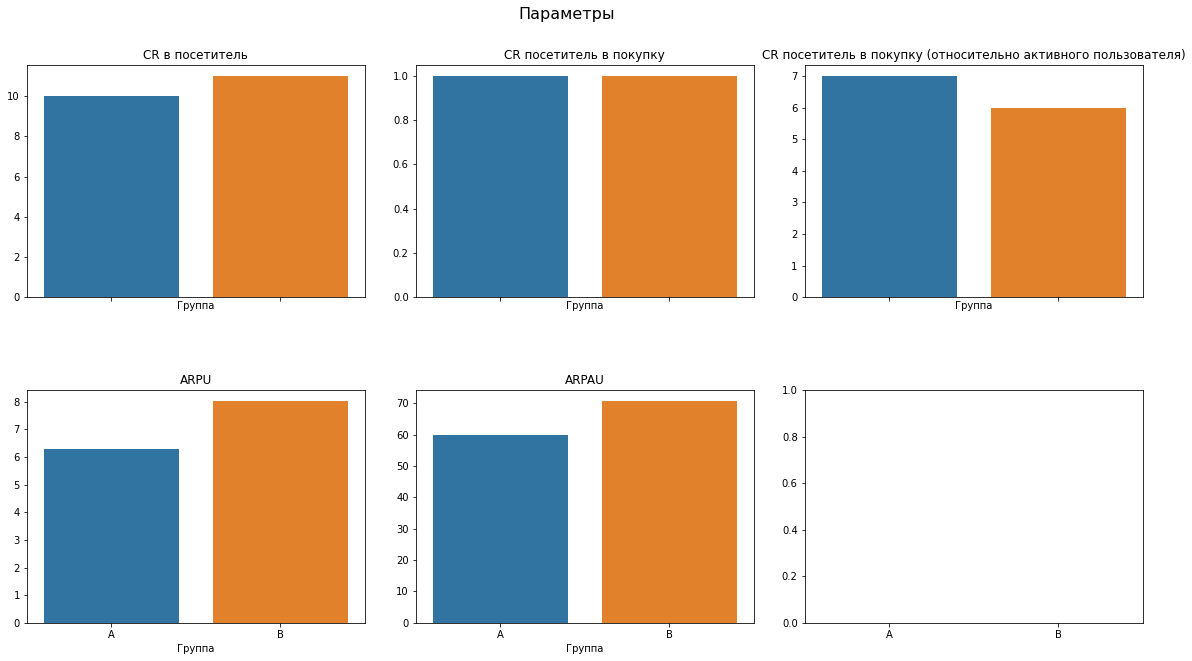

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharex=True)
fig.subplots_adjust(hspace=0.4, wspace=0.15)

columns=df.columns
columns=columns.drop(['Группа'])

fig.suptitle('Параметры', fontsize=16)
for ax,name,col in zip(axes.flatten(),['CR в посетитель','СR посетитель в покупку',\
                                       'CR посетитель в покупку (относительно активного пользователя)',\
                                       'ARPU','ARPAU'],columns):
    sb.barplot(data=df,x=df['Группа'], y=df[col], ax=ax)
    ax.set(ylabel='', xlabel='Группа', title=name)
    
plt.subplots_adjust(top=0.9)

Изходя из тестов, показателей и граффиков можно сделать <b>вывод</b>:

1. Значимых разлиций между покупками не обнаружено (различия статистически незначимы). Возможно виной стоит то что, тест был проведен не корректно, т.к. в тесте колличество эксперементальной группы намного больше, чем контрольная. (Контрольная группа: 14671 , процент от общего колличества:  19.69684764513184 %. Эксперементальная группа: 59813 , процент от общего колличества:  80.30315235486816 %) вызывает подозрение уже (провести тест ~ поровну пользователей). Возможно новый формат оплаты не особо цепляет посетителе сайта (ARPAU всего на 10% происходит повышение). Возможно количество дней "кручения" теста не значительное.<br>
Предлагаю сделать новый тест, где используется равное колличество пользователей, "кручение" теста происходит месяц и каждый день записывется показания.<br><br>
2. Хотя показатели по чекам в эксперементальной группе выше чем у тестовой, я бы не рекомендовал использовать новую технологию оплаты на сайте ( различия между метриками оказались не значительными ).

Главный вопрос: <h1>Стоит ли запускать новую механику на всех пользователей?
    <h3>Мой ответ: Не нужно, отактываем на старую механику или проводим еще раз тест, но с большим временем и с большим деталей изменения или доделываем новую механнику и проводим новый A/B тест заного.<br>
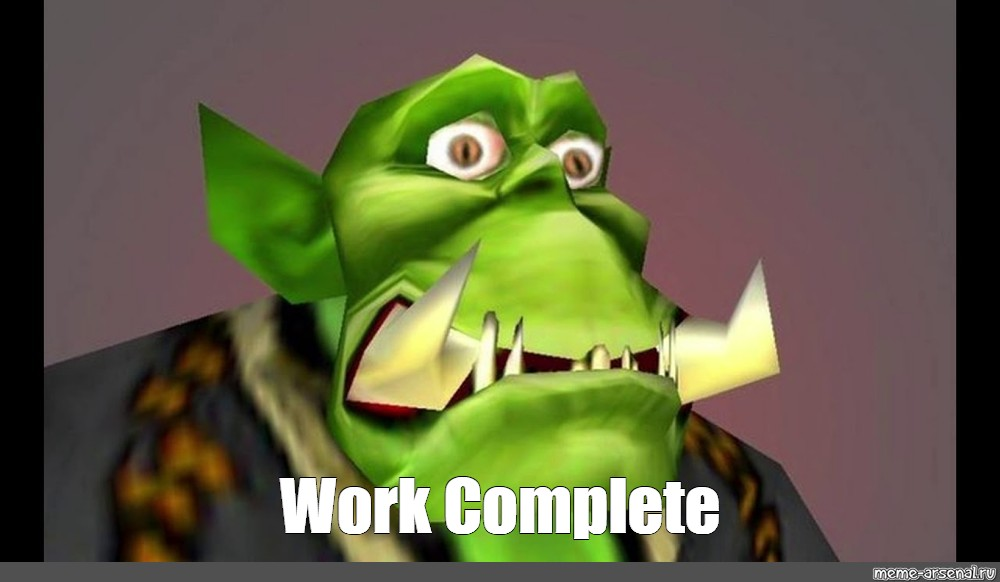

<br><br><br><br><br><br>

In [24]:
import pandahouse as ph

In [25]:
# Объявляем параметры подключения к clickhouse
connection = dict(database='default',
                  host='http://clickhouse.beslan.pro:8080',
                  user='student',
                  password='dpo_python_2020')

<h2>2.1 Выявить, сколько усердных учеников есть на платформе.</h2><br>
Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.<br>
Горошиной называется меленькое задание.<br>

In [27]:
# запрос 
que = """
SELECT
  count(st_id) as Count_var
from
  (
    SELECT
      st_id,
      MONTH(timest) as mon,
      YEAR(timest) as yer,
      sum(correct) as sum_corr
    FROM
      peas
    WHERE
      mon = 3
      and yer = 2020
    GROUP BY
      st_id,
      mon,
      yer
    order by
      sum_corr DESC
  )
where
  sum_corr >= 20
"""

que_answer21 = ph.read_clickhouse(query=que, connection=connection)
print ('Колличество решивших свыше 20 горошен =', que_answer21['Count_var'][0],'.')

Колличество решивших свыше 20 горошен = 0 .


Кажется на платформе никто не усердный. Увы...

<h2>2.2 Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:</h2><br>
<br>
*ARPU <br>
*ARPAU <br>
*CR в покупку <br>
*СR активного пользователя в покупку <br>
*CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

Есть маленькие притензии к этому заданию.<br>
1. St_id – не является типом int, а скорее имеет тип данных string<br>
2. Такое ощущение что метка ученика участвующего в тесте создавалась когда человек заходил выполнял новую горошину.<br>
*200 значений в studs<br>
*200 final<br>
*200 значений peas<br>
Похожи ли st_id в каждой строке? Как мы видим да.<br>

In [28]:
que = """
SELECT *
FROM studs
"""
que_answer1 = ph.read_clickhouse(query=que, connection=connection)
que_answer1

que = """
SELECT st_id
FROM peas
"""
que_answer2 = ph.read_clickhouse(query=que, connection=connection)

que = """
SELECT st_id
FROM final_project_check
"""

que_answer3 = ph.read_clickhouse(query=que, connection=connection)

sch=0
for i in range(que_answer1.shape[0]):
    if que_answer1.st_id[i] == que_answer2.st_id[i] and que_answer1.st_id[i] == que_answer3.st_id[i]:
        sch=sch+1
        continue
print (sch, que_answer1.shape[0])

200 200


In [29]:
que= """
select
  test_grp,
  sum(default.final_project_check.money) / count(DISTINCT default.studs.st_id) as ARPU,
  sum(default.final_project_check.money) / count(DISTINCT default.peas.st_id) as ARPAU,
  count(DISTINCT default.final_project_check.st_id) / count(DISTINCT default.studs.st_id)*100 as CR1,
  count(DISTINCT default.final_project_check.st_id) / count(DISTINCT default.peas.st_id)*100 as CR2,
  count(math.math_studs) / count(math.math_money)*100 as CR3
from
  default.studs as stud
  left join default.peas as pe on stud.st_id = pe.st_id
  left join default.final_project_check as chek ON stud.st_id = chek.st_id
  left join (
    select
      DISTINCT default.peas.st_id as math_studs,
      default.peas.subject as subject,
      default.final_project_check.st_id as math_money
    from
      default.peas
      left join default.final_project_check on math_studs = math_money
    where
      subject = 'math'
  ) as math on default.peas.st_id = math.math_money
group by
  test_grp
"""

que_answer22 = ph.read_clickhouse(query=que, connection=connection)
que_answer22

test_grp          ARPU         ARPAU    CR1    CR2    CR3
0      new  3.832586e+06  3.832586e+06  100.0  100.0  100.0
1      old  4.471207e+06  4.471207e+06  100.0  100.0  100.0

где:<br>
CR1 - CR в покупку <br>
CR2 - СR активного пользователя в покупку <br>
CR3 - CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

Извените за мою придирчивость %) <br>
Решил изменить спомощью запросов таблички, для интереса. (уменьшил колличество покупок с пользователя)

In [30]:
que= """
select
  grp,
  sum(money) / count(grp) ARPU,
  sum(money) / sum(if(count_active > 0, 1, 0)) as ARPAU,
  sum(if(count_buy > 0, 1, 0)) / count(grp) * 100 AS CR1,
  sum(if(count_buy > 0, 1, 0)) / sum(if(count_active > 0, 1, 0)) * 100 AS CR2,
  sum(if(buyM > 0, 1, 0)) / sum(if(actM > 0, 1, 0)) * 100 AS CR3
from(
    select
      b.st_id as id,
      a.num_row as grp,
      b.count_buy as count_buy,
      b.s_money as money,
      d.count_active as count_active,
      b.Math as buyM,
      d.Math as actM
    from(
        select
          if(
            num_row <(
              select
                uniqExact(st_id)
              from
                default.studs
            ) / 2,
            'old',
            'new'
          ) as num_row,
          st_id
        from(
            select
              ROW_NUMBER() OVER() as num_row,
              st_id
            from
              (
                select
                  distinct st_id
                from
                  default.studs
              )
          )
      ) as a
      right join (
        select
          st_id,
          groupArray(DISTINCT subject) as subject_active,
          count(subject) as count_buy,
          sum(money) as s_money,
          sum(if (subject = 'Math', 1, 0)) as Math
        from(
            select
              *
            from(
                SELECT
                  ROW_NUMBER() OVER(PARTITION BY st_id) as row_num,
                  *
                from
                  default.final_project_check
              )
            WHERE
              row_num < 11 / 3
          )
        group by
          st_id
      ) as b on a.st_id = b.st_id
      right join (
        SELECT
          *
        from(
            SELECT
              st_id,
              groupArray(DISTINCT subject) as subj_buy,
              sum(if (subject = 'Math', 1, 0)) as Math,
              count(subject) as count_active
            from
              default.peas
            group by
              st_id
          )
      ) as d on a.st_id = d.st_id
  )
group by
  grp
"""

que_answer22n = ph.read_clickhouse(query=que, connection=connection)
que_answer22n

grp          ARPU         ARPAU    CR1    CR2        CR3
0  new  49687.500000  49687.500000  100.0  100.0  72.727273
1  old  51071.428571  51071.428571  100.0  100.0  50.000000

Ну чтож, поменял я CR3 но уже что то :)

<br><br><br><br><br><br>

In [31]:
import pylab

<h1>Задание 3. Python</h1>
<h2>3.1 Задача</h2> <br>

1.Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.<br><br>
2.Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [11]:
def new_table_pocas(df1, checks, active_studs):
    
    #создание новой группы
    df2    = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/3aARY-P9pfaksg')
    groups = pd.concat([df1, df2], ignore_index=True)
    groups.to_csv('new_group.csv', index=False)
    
    # расчет базовых метрик
    by_chek = checks.merge(groups, on='id') 
    
    mean_chek  = by_chek.groupby('grp',as_index=False).agg({'rev':pd.Series.mean}).rename(columns={'rev':'mean_ch'}) # стредний чек
    max_chek   = by_chek.groupby('grp',as_index=False).agg({'rev':pd.Series.max}).rename(columns={'rev':'max_ch'}) # максимальный чек
    count_chek = by_chek.groupby('grp',as_index=False).agg({'rev':pd.Series.count}).rename(columns={'rev':'count_ch'}) # кооличество чеков
    sum_chek   = by_chek.groupby('grp',as_index=False).agg({'rev':pd.Series.sum}).rename(columns={'rev':'sum_ch'}) # суммарный чек
    join_table_chek = mean_chek.merge(max_chek,on='grp').merge(count_chek,on='grp').merge(sum_chek,on='grp') # сводная
    
    activ_user = active_studs.merge(groups, on='id')
    grp_activ  = activ_user.groupby('grp',as_index=False).agg({'id':pd.Series.count}).rename(columns={'id':'users'})
    
    # расчет сложносоставных метрик
    def CR (grop): # функция для расчета конверсии
        CR_active             = round(activ_user.query("grp==@grop").id.count()/groups.query("grp==@grop").id.count(),2)*100
        CR_active_bying_abs   = round(by_chek.query("grp==@grop").id.count()/groups.query("grp==@grop").id.count(),2)*100
        CR_active_bying_otnos = round(by_chek.query("grp==@grop").id.count()/activ_user.query("grp==@grop").id.count(),2)*100
        return CR_active,CR_active_bying_abs,CR_active_bying_otnos
    
    CR_A  = CR('A')
    CR_B  = CR('B')
    
    def ARPU (grop): # функция для расчета ARPU
        ARPU  = round(by_chek.query("grp==@grop").rev.sum()/groups.query("grp==@grop").id.count(),2)
        ARPAU = round(by_chek.query("grp==@grop").rev.sum()/activ_user.query("grp==@grop").id.count(),2)
        return ARPU,ARPAU
    
    ARPU_A = ARPU('A')
    ARPU_B = ARPU('B') 
    
    group = ['A','B']

    df = pd.DataFrame(columns=['Группа','CR в посетитель','СR посетитель в покупку','CR посетитель в покупку (относительно активного пользователя)','ARPU','ARPAU'])

    CR_active             = [CR_A[0],CR_B[0]]
    CR_active_bying_abs   = [CR_A[1],CR_B[1]]
    CR_active_bying_otnos = [CR_A[2],CR_B[2]]

    ARPU  = [ARPU_A[0],ARPU_B[0]]
    ARPAU = [ARPU_A[1],ARPU_B[1]]

    df['Группа']                                                        = group
    df['CR в посетитель']                                               = CR_active
    df['СR посетитель в покупку']                                       = CR_active_bying_abs 
    df['CR посетитель в покупку (относительно активного пользователя)'] = CR_active_bying_otnos
    df['ARPU']                                                          = ARPU
    df['ARPAU']                                                         = ARPAU
    
    #объединение всех метрик 
    new_table = df.merge(join_table_chek,on=join_table_chek.grp).drop(columns=['key_0','grp']).rename(columns={'mean_ch':\
                        'Средний чек','max_ch':'Максимальный чек', 'count_ch':'Колличество покупок', 'sum_ch':'Суммарный чек'})
     
    return new_table

In [12]:
df = new_table_pocas(groups, checks, active_studs)
df

Группа  CR в посетитель  СR посетитель в покупку  \
0      A             10.0                      1.0   
1      B             11.0                      1.0   

   CR посетитель в покупку (относительно активного пользователя)  ARPU  ARPAU  \
0                                                7.0              6.27  59.88   
1                                                6.0              8.04  70.74   

   Средний чек  Максимальный чек  Колличество покупок  Суммарный чек  
0   860.710280            3660.0                107.0     92096.0000  
1  1108.824893            4650.0                434.0    481230.0036

In [36]:
def figure_plot (df):
    columns=df.columns
    columns=columns.drop(['Группа'])

    sb.set(style="darkgrid")

    for ax,col,i in zip(axes.flatten(),columns,range(9)):
        plt.figure(figsize=[20,20])
        pylab.subplot(5,2,i+1)
        sb.barplot(data=df,x=df['Группа'], y=df[col])
        pylab.xlabel('')
        pylab.ylabel('')
        pylab.title(col)

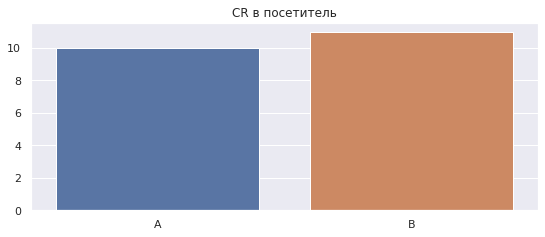

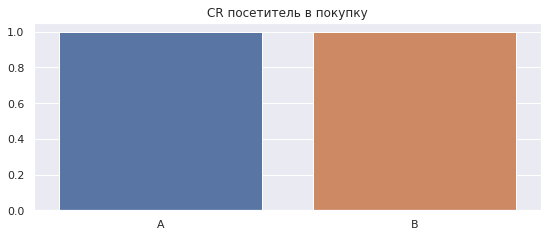

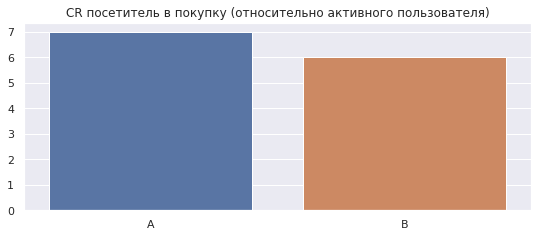

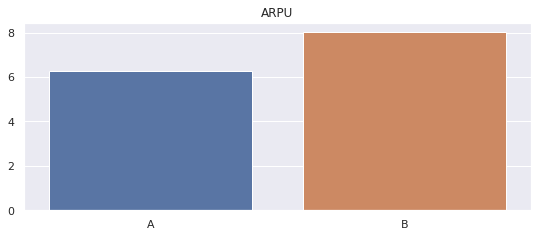

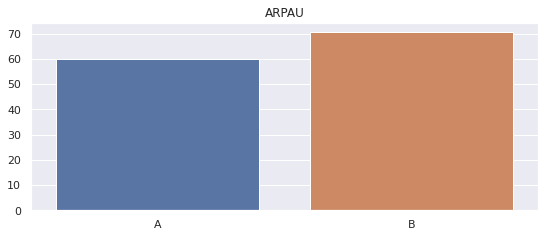

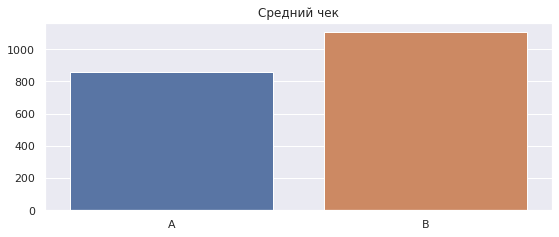

In [37]:
figure_plot (df)

<br><br><br><br><br><br>
Спасибо за проект. Я знатно постарался чтобы его сделать, надеюсь его Вам будет приятно проверять! <br>
Для простоты я еще сделал проекты по разным notebook'ам.<br><br>
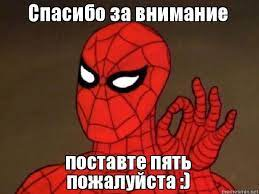